**CSI 4142 Data Science** <br/>
*Assignment 3: Predictive Analysis and Classification*

# Identification

Name: Eli Wynn<br/>
Student Number: 300248135

Name: Jack Snelgrove<br/>
Student Number: 300247435


Our datasets have been uploaded from the public repository:

- [github.com/eli-wynn/Datasets](https://github.com/eli-wynn/Datasets)

# Imports

In [24]:
#configure database -> can't use github because files are too large
#!pip install kaggle
#!pip install python-Levenshtein
#Run the above lines if library has not been previously installed


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import kaggle
import Levenshtein
import re
import ast
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN


In [26]:
# Load the dataset
import os
import kaggle

# Set environment variables
os.environ["KAGGLE_USERNAME"] = "eliwynn"
os.environ["KAGGLE_KEY"] = "c71d95504bba7ec81de8ed35ec02b166"

# Download the dataset
dataset = "rounakbanik/the-movies-dataset"
download_path = "./movies_dataset"

#download entire dataset
kaggle.api.dataset_download_files(dataset, download_path, unzip=True)

metadataDF = pd.read_csv(f"{download_path}/movies_metadata.csv")
metadataDF.head()
ratingsDF = pd.read_csv(f"{download_path}/ratings.csv")
ratingsDF.head()

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset


C:\Users\eliwy\AppData\Local\Temp\ipykernel_27492\1111194188.py:16: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadataDF = pd.read_csv(f"{download_path}/movies_metadata.csv")


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


# **Dataset Description**

## **Overview**
| Attribute | Description |
|-----------|-------------|
| Dataset Name | The Movies Dataset |
| Author | Rounak Banik |
| Purpose | Provides metadata and ratings for movies to facilitate film analysis and recommendation system development |
| Shape | 45,466 rows × 24 columns (movies metadata), 100,004 rows × 4 columns (ratings) |

## **Features**

### **Movies Metadata (`movies_metadata.csv`)**
| Feature Name | Type | Description |
|-------------|------|-------------|
| id | Categorical | Unique identifier for each movie |
| title | Categorical | Title of the movie |
| release_date | DateTime | Release date of the movie |
| budget | Numerical | Production budget in USD |
| revenue | Numerical | Box office revenue in USD |
| genres | Categorical | List of genres associated with the movie |
| popularity | Numerical | Popularity score based on TMDb metrics |
| vote_average | Numerical | Average user rating (0-10) |
| vote_count | Numerical | Total number of votes received |
| production_companies | Categorical | List of companies that produced the movie |
| production_countries | Categorical | Countries where the movie was produced |
| runtime | Numerical | Duration of the movie in minutes |
| spoken_languages | Categorical | List of languages spoken in the movie |

### **Ratings (`ratings_small.csv`)**
| Feature Name | Type | Description |
|-------------|------|-------------|
| userId | Categorical | Unique identifier for each user |
| movieId | Categorical | Unique identifier for each movie (links to `id` in movies metadata) |
| rating | Numerical | User rating of the movie (0.5 - 5.0) |
| timestamp | DateTime | Unix timestamp of when the rating was given |


## Data Preparation

In [27]:
def prepare_movie_datasets():
    """
    Prepare the movie datasets (movies_metadata.csv and ratings_small.csv)
    """

    metadataDF = pd.read_csv('./movies_dataset/movies_metadata.csv', low_memory=False)
    ratingsDF = pd.read_csv('./movies_dataset/ratings_small.csv')
    
    # Display basic information
    print("Movies Metadata Shape:", metadataDF.shape)
    print("Ratings Shape:", ratingsDF.shape)
    
    # Clean the movies dataset
    print("Cleaning movies dataset...")
    
    # Convert 'id' to numeric, coercing errors to NaN
    metadataDF['id'] = pd.to_numeric(metadataDF['id'], errors='coerce')
    
    # Drop rows with NaN in 'id'
    metadataDF = metadataDF.dropna(subset=['id'])
    
    # Convert 'id' to integer
    metadataDF['id'] = metadataDF['id'].astype(int)
    
    # Select relevant columns
    metadataDF = metadataDF[['id', 'title', 'release_date', 'popularity', 'vote_average', 'vote_count', 'budget', 'revenue', 'runtime', 'genres', 'overview']]
    
    # Convert date column to datetime
    metadataDF['release_date'] = pd.to_datetime(metadataDF['release_date'], errors='coerce')
    
    # Extract year from release_date
    metadataDF['release_year'] = metadataDF['release_date'].dt.year
    
    # Drop rows with missing values in important columns
    metadataDF = metadataDF.dropna(subset=['release_year', 'popularity', 'vote_average', 'vote_count'])
    
    # Convert numeric columns to appropriate types
    numeric_cols = ['popularity', 'vote_average', 'vote_count', 'budget', 'revenue', 'runtime']
    for col in numeric_cols:
        metadataDF[col] = pd.to_numeric(metadataDF[col], errors='coerce')
    
    # Fill missing values with median
    for col in numeric_cols:
        metadataDF[col] = metadataDF[col].fillna(metadataDF[col].median())
    
    # Prepare the ratings dataset
    print("Preparing ratings dataset...")
    
    # Rename movieId to match with metadataDF id
    ratingsDF = ratingsDF.rename(columns={'movieId': 'id'})
    
    # Merge datasets
    print("Merging datasets...")
    merged_df = pd.merge(ratingsDF, metadataDF, on='id', how='inner')
    
    print("Merged dataset shape:", merged_df.shape)
    
    # Create features and target
    # Target: High rating (1 if rating >= 4.0, 0 otherwise)
    merged_df['high_rating'] = (merged_df['rating'] >= 4.0).astype(int)
    
    # Features: movie attributes
    features = ['popularity', 'vote_average', 'vote_count', 'budget', 'revenue', 'runtime', 'release_year']
    X = merged_df[features]
    y = merged_df['high_rating']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Movie datasets prepared successfully!")
    return X_train_scaled, X_test_scaled, y_train, y_test, merged_df, metadataDF

## Study 1: Similarity Measures

In [28]:
X_train, X_test, y_train, y_test, merged_df, metadataDF = prepare_movie_datasets()

# Helper functions for processing movie data
def extract_genres(genres_json):
    """Extract genre names from the JSON string in the genres column"""
    try:
        if isinstance(genres_json, str):
            genres = ast.literal_eval(genres_json)
            return [genre['name'] for genre in genres]
        else:
            return []
    except:
        return []

def clean_title(title):
    """Clean title for better similarity matching"""
    if pd.isna(title):
        return ""
    # Remove special characters and convert to lowercase
    return re.sub(r'[^\w\s]', '', title).lower()

def extract_keywords(overview):
    """Extract keywords from overview text"""
    if pd.isna(overview):
        return ""
    # Simple keyword extraction - remove stopwords and keep only words with 4+ characters
    words = re.findall(r'\b\w{4,}\b', overview.lower())
    # Remove common stopwords
    stopwords = ['this', 'that', 'with', 'from', 'have', 'they', 'will', 'what', 'when', 'where', 'which']
    return ' '.join([w for w in words if w not in stopwords])

# Prepare additional features for similarity measures
print("Preparing data for similarity measures...")
metadataDF['genres_list'] = metadataDF['genres'].apply(extract_genres)
metadataDF['clean_title'] = metadataDF['title'].apply(clean_title)
metadataDF['keywords'] = metadataDF['overview'].apply(extract_keywords)

# 1. Jaccard Similarity for Genres
def jaccard_similarity_genres(movie_data, movie_title):
    """
    Jaccard similarity for genres
    Jaccard(A,B) = |A ∩ B| / |A ∪ B|
    """
    # Find the movie by title
    movie = movie_data[movie_data['title'] == movie_title]
    if len(movie) == 0:
        print(f"Movie '{movie_title}' not found. Please check the title.")
        return []
    
    movie = movie.iloc[0]
    movie_genres = set(movie['genres_list'])
    
    # Calculate Jaccard similarity for all movies
    similarities = []
    for idx, row in movie_data.iterrows():
        other_genres = set(row['genres_list'])
        if not movie_genres or not other_genres:
            sim = 0
        else:
            intersection = len(movie_genres.intersection(other_genres))
            union = len(movie_genres.union(other_genres))
            sim = intersection / union if union > 0 else 0
        similarities.append((row['title'], sim, row['genres_list'], row['popularity']))
    
    # Sort by similarity (descending) and then by popularity (descending)
    return sorted(similarities, key=lambda x: (-x[1], -x[3]))

# 2. Euclidean Similarity for Revenue
def euclidean_similarity_revenue(movie_data, movie_title):
    """
    Euclidean distance for revenue
    Converted to similarity: 1 / (1 + distance)
    """
    # Find the movie by title
    movie = movie_data[movie_data['title'] == movie_title]
    if len(movie) == 0:
        print(f"Movie '{movie_title}' not found. Please check the title.")
        return []
    
    movie = movie.iloc[0]
    movie_revenue = movie['revenue']
    
    # Calculate Euclidean similarity for all movies
    similarities = []
    for idx, row in movie_data.iterrows():
        other_revenue = row['revenue']
        # Calculate Euclidean distance
        distance = abs(movie_revenue - other_revenue)
        # Convert to similarity (higher is more similar)
        sim = 1 / (1 + distance/1e6)  # Normalize by dividing by 1 million
        similarities.append((row['title'], sim, row['revenue'], row['popularity']))
    
    # Sort by similarity (descending) and then by popularity (descending)
    return sorted(similarities, key=lambda x: (-x[1], -x[3]))

# 3. Manhattan Similarity for Runtime
def manhattan_similarity_runtime(movie_data, movie_title):
    """
    Manhattan distance for runtime
    Converted to similarity: 1 / (1 + distance)
    """
    # Find the movie by title
    movie = movie_data[movie_data['title'] == movie_title]
    if len(movie) == 0:
        print(f"Movie '{movie_title}' not found. Please check the title.")
        return []
    
    movie = movie.iloc[0]
    movie_runtime = movie['runtime']
    
    # Calculate Manhattan similarity for all movies
    similarities = []
    for idx, row in movie_data.iterrows():
        other_runtime = row['runtime']
        # Calculate Manhattan distance
        distance = abs(movie_runtime - other_runtime)
        # Convert to similarity (higher is more similar)
        sim = 1 / (1 + distance/10)  # Normalize by dividing by 10
        similarities.append((row['title'], sim, row['runtime'], row['popularity']))
    
    # Sort by similarity (descending) and then by popularity (descending)
    return sorted(similarities, key=lambda x: (-x[1], -x[3]))

# 4. Levenshtein (Edit Distance) Similarity for Title
def levenshtein_similarity_title(movie_data, movie_title):
    """
    Levenshtein (edit) distance for titles
    Converted to similarity: 1 - (distance / max_length)
    """
    # Find the movie by title
    movie = movie_data[movie_data['title'] == movie_title]
    if len(movie) == 0:
        print(f"Movie '{movie_title}' not found. Please check the title.")
        return []
    
    movie = movie.iloc[0]
    movie_clean_title = movie['clean_title']
    
    # Calculate Levenshtein similarity for all movies
    similarities = []
    for idx, row in movie_data.iterrows():
        other_clean_title = row['clean_title']
        # Calculate Levenshtein distance
        distance = Levenshtein.distance(movie_clean_title, other_clean_title)
        # Convert to similarity (higher is more similar)
        max_len = max(len(movie_clean_title), len(other_clean_title))
        sim = 1 - (distance / max_len) if max_len > 0 else 0
        similarities.append((row['title'], sim, distance, row['popularity']))
    
    # Sort by similarity (descending) and then by popularity (descending)
    return sorted(similarities, key=lambda x: (-x[1], -x[3]))

# 5. Cosine Similarity for Budget
def cosine_similarity_budget(movie_data, movie_title):
    """
    Cosine similarity for budget
    """
    # Find the movie by title
    movie = movie_data[movie_data['title'] == movie_title]
    if len(movie) == 0:
        print(f"Movie '{movie_title}' not found. Please check the title.")
        return []
    
    movie = movie.iloc[0]
    movie_budget = movie['budget']
    
    # Calculate Cosine similarity for all movies
    similarities = []
    for idx, row in movie_data.iterrows():
        other_budget = row['budget']
        # Calculate Cosine similarity
        if movie_budget == 0 and other_budget == 0:
            sim = 1  # Both budgets are 0, consider them similar
        elif movie_budget == 0 or other_budget == 0:
            sim = 0  # One budget is 0, the other isn't
        else:
            # Cosine similarity for 1D is just the dot product divided by magnitudes
            sim = (movie_budget * other_budget) / (abs(movie_budget) * abs(other_budget))
        similarities.append((row['title'], sim, row['budget'], row['popularity']))
    
    # Sort by similarity (descending) and then by popularity (descending)
    return sorted(similarities, key=lambda x: (-x[1], -x[3]))

def display_results(results, title, attribute_name, top_n=10):
    """Display the top N results in a formatted way"""
    print(f"\n--- Top {top_n} movies with similar {attribute_name} to '{title}' ---")
    
    # Create a DataFrame for better display in notebook
    result_df = pd.DataFrame([
        {
            'Title': movie_title,
            'Similarity': f"{similarity:.4f}",
            f'{attribute_name.capitalize()}': attribute,
            'Popularity': f"{popularity:.2f}"
        }
        for movie_title, similarity, attribute, popularity in results[:top_n+1]
        if movie_title != title  # Skip the query movie itself
    ][:top_n])
    
    display(result_df)
    
    return result_df

# Run the similarity study
print("\n=== Study 1 – Similarity Measures ===")

# Define query movies
toy_story = "Toy Story"
titanic = "Titanic"
apollo_13 = "Apollo 13"
fight_club = "Fight Club"
matrix = "The Matrix"

# Verify movies exist in the dataset
for movie in [toy_story, titanic, apollo_13, fight_club, matrix]:
    if movie not in metadataDF['title'].values:
        print(f"Warning: '{movie}' not found in dataset. Using a similar title.")
        # Find closest match
        closest = metadataDF.iloc[metadataDF['title'].apply(
            lambda x: Levenshtein.distance(str(x).lower(), movie.lower())).argmin()]['title']
        print(f"Using '{closest}' instead of '{movie}'")
        if movie == toy_story:
            toy_story = closest
        elif movie == titanic:
            titanic = closest
        elif movie == apollo_13:
            apollo_13 = closest
        elif movie == fight_club:
            fight_club = closest
        elif movie == matrix:
            matrix = closest

# 1. Jaccard similarity for genres
print("\nRequest 1: Show me movies of the same genre as 'Toy Story'")
genre_results = jaccard_similarity_genres(metadataDF, toy_story)
genre_df = display_results(genre_results, toy_story, "genres")

# 2. Euclidean similarity for revenue
print("\nRequest 2: Show me movies with similar revenue to 'Titanic'")
revenue_results = euclidean_similarity_revenue(metadataDF, titanic)
revenue_df = display_results(revenue_results, titanic, "revenue")

# 3. Manhattan similarity for runtime
print("\nRequest 3: Show me movies with similar length as 'Apollo 13'")
runtime_results = manhattan_similarity_runtime(metadataDF, apollo_13)
runtime_df = display_results(runtime_results, apollo_13, "runtime (minutes)")

# 4. Levenshtein similarity for title
print("\nRequest 4: Show me movies with similar title to 'Fight Club'")
title_results = levenshtein_similarity_title(metadataDF, fight_club)
title_df = display_results(title_results, fight_club, "title")

# 5. Cosine similarity for budget
print("\nRequest 5: Show me movies with similar budget to 'The Matrix'")
budget_results = cosine_similarity_budget(metadataDF, matrix)
budget_df = display_results(budget_results, matrix, "budget")

# Store all results for further analysis
similarity_results = {
    'genre': genre_df,
    'revenue': revenue_df,
    'runtime': runtime_df,
    'title': title_df,
    'budget': budget_df
}



Movies Metadata Shape: (45466, 24)
Ratings Shape: (100004, 4)
Cleaning movies dataset...
Preparing ratings dataset...
Merging datasets...
Merged dataset shape: (44965, 15)
Movie datasets prepared successfully!
Preparing data for similarity measures...

=== Study 1 – Similarity Measures ===

Request 1: Show me movies of the same genre as 'Toy Story'

--- Top 10 movies with similar genres to 'Toy Story' ---


,Title,Similarity,Genres,Popularity
0,The Emoji Movie,1.0000,"[Comedy, Family, Animation]",33.69
1,"Monsters, Inc.",1.0000,"[Animation, Comedy, Family]",26.42
2,Despicable Me 2,1.0000,"[Animation, Comedy, Family]",24.82
3,Chicken Little,1.0000,"[Animation, Family, Comedy]",18.58
4,Toy Story 2,1.0000,"[Animation, Comedy, Family]",17.55
5,Toy Story 3,1.0000,"[Animation, Family, Comedy]",16.97
6,Cloudy with a Chance of Meatballs 2,1.0000,"[Animation, Family, Comedy]",14.41
7,The Simpsons Movie,1.0000,"[Animation, Comedy, Family]",14.30
8,Looney Tunes: Back in Action,1.0000,"[Animation, Comedy, Family]",13.67
9,The Boss Baby,1.0000,"[Animation, Comedy, Family]",13.39



Request 2: Show me movies with similar revenue to 'Titanic'

--- Top 10 movies with similar revenue to 'Titanic' ---


,Title,Similarity,Revenue,Popularity
0,Star Wars: The Force Awakens,0.0045,2.068224e+09,31.63
1,The Avengers,0.0031,1.519558e+09,89.89
2,Jurassic World,0.0030,1.513529e+09,32.79
3,Furious 7,0.0029,1.506249e+09,27.28
4,Avengers: Age of Ultron,0.0023,1.405404e+09,37.38
5,Harry Potter and the Deathly Hallows: Part 2,0.0020,1.342000e+09,24.99
6,Frozen,0.0017,1.274219e+09,24.25
7,Beauty and the Beast,0.0017,1.262886e+09,287.25
8,The Fate of the Furious,0.0016,1.238765e+09,48.57
9,Iron Man 3,0.0016,1.215440e+09,23.72



Request 3: Show me movies with similar length as 'Apollo 13'

--- Top 10 movies with similar runtime (minutes) to 'Apollo 13' ---


,Title,Similarity,Runtime (minutes),Popularity
0,War for the Planet of the Apes,1.0000,140.0,146.16
1,Operation Mekong,1.0000,140.0,35.97
2,Batman Begins,1.0000,140.0,28.51
3,The Lost City of Z,1.0000,140.0,21.79
4,Hacksaw Ridge,1.0000,140.0,21.04
5,Star Wars: Episode III - Revenge of the Sith,1.0000,140.0,13.17
6,Warrior,1.0000,140.0,13.12
7,La Vie en Rose,1.0000,140.0,11.71
8,The Karate Kid,1.0000,140.0,11.69
9,Death on the Nile,1.0000,140.0,11.16



Request 4: Show me movies with similar title to 'Fight Club'

--- Top 10 movies with similar title to 'Fight Club' ---


,Title,Similarity,Popularity
0,4,0.6364,5.42
1,4,0.6364,0.14
2,4,0.6000,3.53
3,4,0.6000,0.57
4,4,0.6000,0.48
5,4,0.6000,0.44
6,7,0.5882,3.80
7,5,0.5455,13.88
8,5,0.5455,5.56
9,5,0.5455,5.27



Request 5: Show me movies with similar budget to 'The Matrix'

--- Top 10 movies with similar budget to 'The Matrix' ---


,Title,Similarity,Budget,Popularity
0,Minions,1.0000,74000000,547.49
1,Wonder Woman,1.0000,149000000,294.34
2,Beauty and the Beast,1.0000,160000000,287.25
3,Baby Driver,1.0000,34000000,228.03
4,Big Hero 6,1.0000,165000000,213.85
5,Deadpool,1.0000,58000000,187.86
6,Guardians of the Galaxy Vol. 2,1.0000,200000000,185.33
7,Avatar,1.0000,237000000,185.07
8,John Wick,1.0000,20000000,183.87
9,Gone Girl,1.0000,61000000,154.80


## Study 2: Clustering Algorithms

Loaded 5381 movies.

Performing KMeans clustering...

Performing DBSCAN clustering...

Visualizing clustering results...


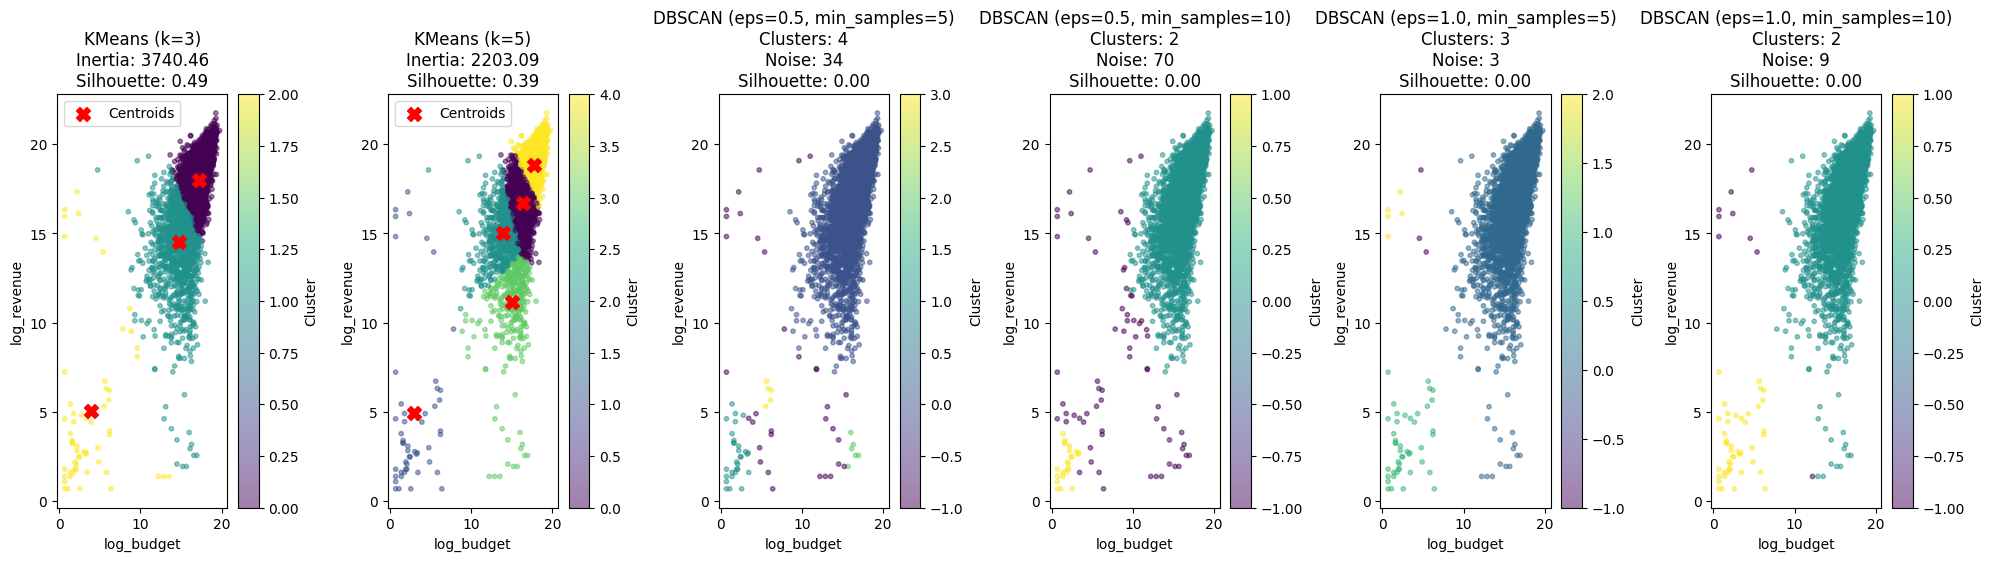

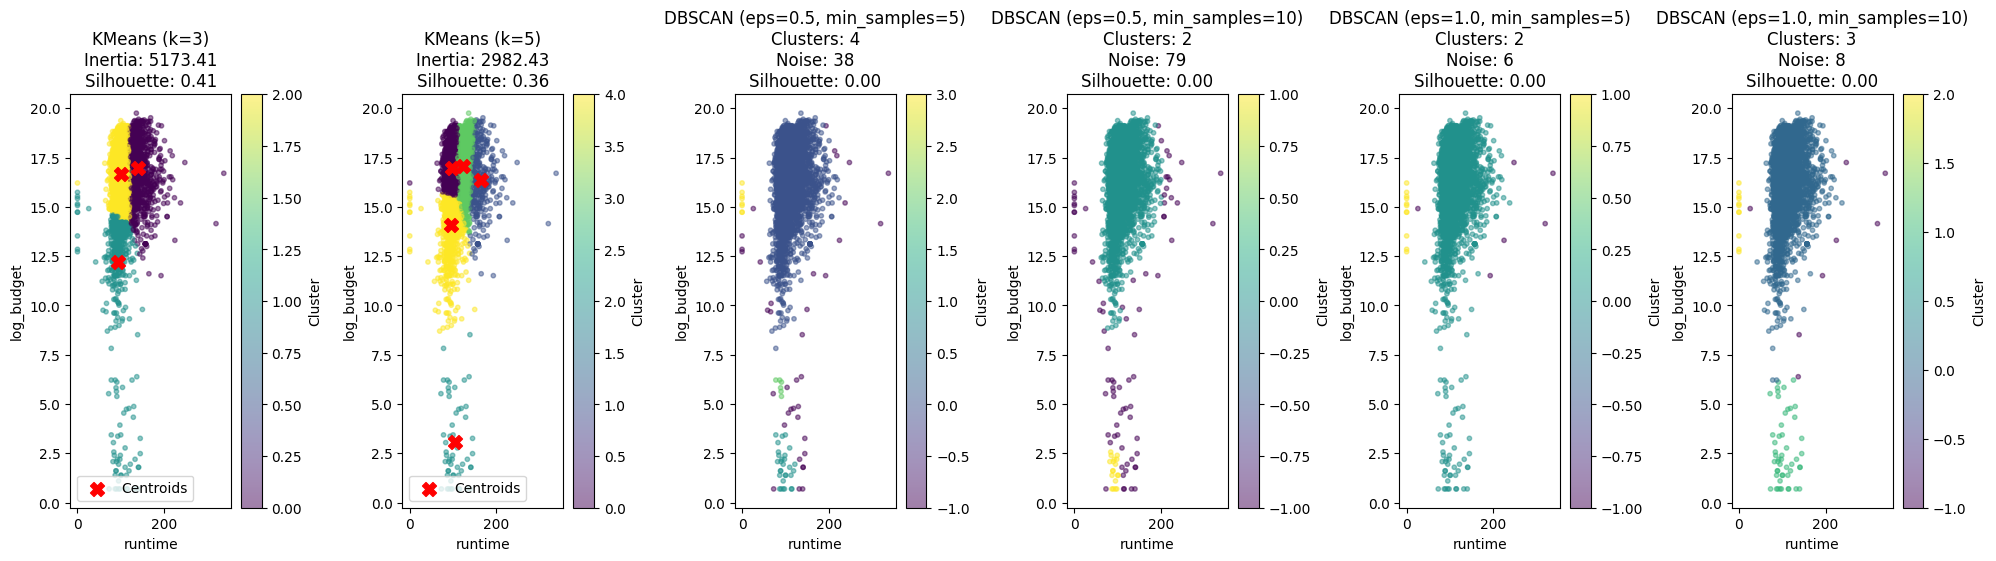


Clustering study completed!


In [38]:
# Function to perform KMeans clustering
def perform_kmeans(data, feature_pairs, k_values):
    results = {}
    
    for features in feature_pairs:
        feature_name = f"{features[0]}_vs_{features[1]}"
        results[feature_name] = {}
        
        # Extract features
        X = data[list(features)].values
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        for k in k_values:
            # Perform KMeans clustering
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(X_scaled)
            
            # Calculate silhouette score if k > 1
            if k > 1:
                silhouette = silhouette_score(X_scaled, clusters)
            else:
                silhouette = 0  # Not applicable for k=1
            
            # Store results
            results[feature_name][k] = {
                'clusters': clusters,
                'centers': scaler.inverse_transform(kmeans.cluster_centers_),
                'inertia': kmeans.inertia_,
                'silhouette': silhouette
            }
    
    return results

# Function to perform DBSCAN clustering
def perform_dbscan(data, feature_pairs, eps_values, min_samples_values):
    results = {}
    
    for features in feature_pairs:
        feature_name = f"{features[0]}_vs_{features[1]}"
        results[feature_name] = {}
        
        # Extract features
        X = data[list(features)].values
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        for eps in eps_values:
            for min_samples in min_samples_values:
                param_key = f"eps_{eps}_min_samples_{min_samples}"
                
                # Perform DBSCAN clustering
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                clusters = dbscan.fit_predict(X_scaled)
                
                # Calculate silhouette score if more than one cluster and no noise points (-1)
                unique_clusters = np.unique(clusters)
                if len(unique_clusters) > 1 and -1 not in unique_clusters:
                    silhouette = silhouette_score(X_scaled, clusters)
                else:
                    silhouette = 0  # Not applicable
                
                # Store results
                results[feature_name][param_key] = {
                    'clusters': clusters,
                    'n_clusters': len(np.unique(clusters[clusters >= 0])),
                    'n_noise': np.sum(clusters == -1),
                    'silhouette': silhouette
                }
    
    return results

# Function to visualize clustering results
def visualize_clustering(data, feature_pairs, kmeans_results, dbscan_results, k_values, eps_values, min_samples_values):
    for features in feature_pairs:
        feature_name = f"{features[0]}_vs_{features[1]}"
        x_label = features[0]
        y_label = features[1]
        
        # Create figure for this feature pair
        fig = plt.figure(figsize=(20, 10))
        
        # Plot KMeans results
        for i, k in enumerate(k_values):
            ax = fig.add_subplot(2, len(k_values) + len(eps_values) * len(min_samples_values), i + 1)
            
            # Get cluster assignments
            clusters = kmeans_results[feature_name][k]['clusters']
            centers = kmeans_results[feature_name][k]['centers']
            
            # Plot data points colored by cluster
            scatter = ax.scatter(data[x_label], data[y_label], c=clusters, cmap='viridis', 
                       alpha=0.5, s=10)
            
            # Plot cluster centers
            ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=100, label='Centroids')
            
            ax.set_title(f'KMeans (k={k})\nInertia: {kmeans_results[feature_name][k]["inertia"]:.2f}\nSilhouette: {kmeans_results[feature_name][k]["silhouette"]:.2f}')
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)
            ax.legend()
            
            # Add colorbar
            plt.colorbar(scatter, ax=ax, label='Cluster')
        
        # Plot DBSCAN results
        plot_idx = len(k_values) + 1
        for eps in eps_values:
            for min_samples in min_samples_values:
                param_key = f"eps_{eps}_min_samples_{min_samples}"
                
                ax = fig.add_subplot(2, len(k_values) + len(eps_values) * len(min_samples_values), plot_idx)
                
                # Get cluster assignments
                clusters = dbscan_results[feature_name][param_key]['clusters']
                
                # Plot data points colored by cluster
                scatter = ax.scatter(data[x_label], data[y_label], c=clusters, cmap='viridis', 
                           alpha=0.5, s=10)
                
                ax.set_title(f'DBSCAN (eps={eps}, min_samples={min_samples})\nClusters: {dbscan_results[feature_name][param_key]["n_clusters"]}\nNoise: {dbscan_results[feature_name][param_key]["n_noise"]}\nSilhouette: {dbscan_results[feature_name][param_key]["silhouette"]:.2f}')
                ax.set_xlabel(x_label)
                ax.set_ylabel(y_label)
                
                # Add colorbar
                plt.colorbar(scatter, ax=ax, label='Cluster')
                
                plot_idx += 1
        
        plt.tight_layout()
        plt.savefig(f'clustering_{feature_name}.png', dpi=300)
        plt.show()

# Main function to run the clustering study
def run_clustering_study(metadataDF):
    movie_data = metadataDF.copy()
    movie_data = movie_data[(movie_data['budget'] > 0) & (movie_data['revenue'] > 0)]
    
    # Log transform budget and revenue (they're highly skewed)
    movie_data['log_budget'] = np.log1p(metadataDF['budget'])
    movie_data['log_revenue'] = np.log1p(movie_data['revenue'])
    print(f"Loaded {len(movie_data)} movies.")
    
    # Define feature pairs to analyze
    feature_pairs = [
        ('log_budget', 'log_revenue'),  # Budget vs Revenue
        ('runtime', 'log_budget')       # Runtime vs Budget
    ]
    
    # Define parameters to test
    k_values = [3, 5]                   # Number of clusters for KMeans
    eps_values = [0.5, 1.0]             # Epsilon values for DBSCAN
    min_samples_values = [5, 10]        # Minimum samples for DBSCAN
    
    # Perform clustering
    print("\nPerforming KMeans clustering...")
    kmeans_results = perform_kmeans(movie_data, feature_pairs, k_values)
    
    print("\nPerforming DBSCAN clustering...")
    dbscan_results = perform_dbscan(movie_data, feature_pairs, eps_values, min_samples_values)
    
    # Visualize results
    print("\nVisualizing clustering results...")
    visualize_clustering(movie_data, feature_pairs, kmeans_results, dbscan_results, 
                        k_values, eps_values, min_samples_values)
    
    print("\nClustering study completed!")

if __name__ == "__main__":
    run_clustering_study(metadataDF)

The visualizations suggest that a hybrid approach might be optimal - using DBSCAN for initial outlier detection and pattern discovery, followed by KMeans on the core data points for more structured segmentation. DBSCAN seems to work better for identifying natural clusters in the log budget vs log revenue relationship because there is a strong positive correlation between the two variables. KMeans seems more effective for the runtime vs log revenue relationship because there is a weaker positive correlation and there are fewer clusters so forcing all of the points together would work better.

### References:
- Clustering Algorithm KBmeans: https://www.w3schools.com/python/python_ml_k-means.asp